In [53]:
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn import linear_model
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.svm import SVC
import GO_utils
import utils
from os import listdir, makedirs
from os.path import isfile, join, exists
from scipy.stats import cumfreq

In [58]:
def get_go_terms():
    f_name = '../data/GO_terms_final_gene_counts.txt'
    GO_counts_file = open(f_name)

    terms = []
    for (i, line) in enumerate(GO_counts_file):
        if i < 2:
            continue
        term = line.split('\t')[0]
        terms.append(term)
    return terms

def get_tissue_list(tissue_fpath):
    tissue_file = open(tissue_fpath)
    for line in tissue_file:
        tissues = line.rstrip().split('\t')
        break
    return tissues

def get_1_tissue_aucs(GO_term, tissue_list):
    """
    This function gets the AUC scores of predicting the gene associations of 
    |GO_term| where each prediction task only used features from an individual
    tissue.
    
    :param GO_term: The GO term
    :param tissue_list: List of tissues that were used for separate prediction
    tasks. If len(tissue_list)=53, then we performed 53 separate prediciton
    problems, where each prediction problem used a different 1 of the 53 tissues.
    :return: A list of AUC scores in the same order as |tissue_list|. The ith element in this
    list is the AUC score for predicting this GO term using only tissue i.
    """
    
    aucs_1_tissue = []
    results_dir = 'pca_results_1_tissue/' + GO_term + '/'
    for tissue in tissue_list:
        # Get the AUC score when using features from only this tissue
        f_name = results_dir + 'logreg_' + tissue + '.txt'
        rf = open(f_name)
        for (i, line) in enumerate(rf):
            if i == 2:
                auc_score = float(line.split(' ')[-1])
                aucs_1_tissue.append(auc_score)
            elif i > 2:
                break
    return aucs_1_tissue

def get_all_1_tissue_aucs(GO_terms, tissue_list):
    aucs = np.zeros(shape=(len(GO_terms),len(tissue_list)))  # aucs[i][j] is auc score for using jth tissue features to predict ith GO term
    for (i, term) in enumerate(GO_terms):
        aucs[i, :] = get_1_tissue_aucs(term, tissue_list)
    return aucs

#def get_all_feature_aucs():

In [55]:
def map_GO_to_GTEX():
    inputFilename = '../data/GO_terms_final_gene_counts.txt'
    GO_list_file = open(inputFilename)
    GO_list = np.loadtxt(GO_list_file,skiprows=2,usecols=[0],dtype='S10',delimiter='\t')
    
    inputFilename = '../data/Tissue_Name_Mappings.csv'
    tissue_data = pd.read_csv(inputFilename,header=None)
    map_BTO_to_GTEX = defaultdict(list)

    for index,row in tissue_data.iterrows():
        GTEX_tissue = row[0]
        BTO_tissues = row[1:]
        for tissue in BTO_tissues.dropna():
            map_BTO_to_GTEX[tissue].append(GTEX_tissue)

    inputFilename = '../data/BTO_GO.csv'
    BTO_data = pd.read_csv(inputFilename,skiprows=[0])
    map_GO_to_GTEX = defaultdict(list)

    for index,row in BTO_data.iterrows():
        tissue = row[1]
        if tissue in map_BTO_to_GTEX:
            GO_IDs = row[2:]
            for GO_ID in GO_IDs.dropna():
                if GO_ID in GO_list:
                    map_GO_to_GTEX[GO_ID] = list(set(map_GO_to_GTEX[GO_ID] + map_BTO_to_GTEX[tissue]))

    #inputFile.close()
    return map_GO_to_GTEX

def map_GTEX_to_GO(map_GO_to_GTEX):
    GTEX_to_GO = defaultdict(list)
    for GO_ID,tissues in map_GO_to_GTEX.items():
        for tissue in tissues:
            if GO_ID not in GTEX_to_GO[tissue]:
                GTEX_to_GO[tissue].append(GO_ID)
    return GTEX_to_GO
   
def map_GTEX_to_cols(dir_path, tissues):
    GTEX_to_samples = {}
    for tissue in tissues:
        cols = []
        fpath = dir_path + 'tissue_meta_' + tissue + '.txt'
        meta_file = open(fpath)
        for (i, line) in enumerate(meta_file):
            if i < 1:
                continue
            else:
                cols.append(int(line.split('\t')[0]))
        GTEX_to_samples[tissue] = cols
        meta_file.close()
    return GTEX_to_samples

In [56]:
def make_boxplot(vals, labels):
    plt.figure(figsize=(18, 6))
    plt.margins(0.01)
    plt.ylim([0, 1])
    ax = plt.gca()
    ax.xaxis.grid(which='both')
    plt.xticks(range(len(labels)), labels, rotation='vertical')
    ax.boxplot(vals, labels=labels)
    plt.show()

In [62]:
GO_terms = get_go_terms()
GO_terms.reverse()
all_tissues = get_tissue_list('../data/tissues.txt')
aucs = get_all_1_tissue_aucs(GO_terms, all_tissues)

In [63]:
GO_to_GTEX = map_GO_to_GTEX()
GTEX_to_GO = map_GTEX_to_GO(GO_to_GTEX)

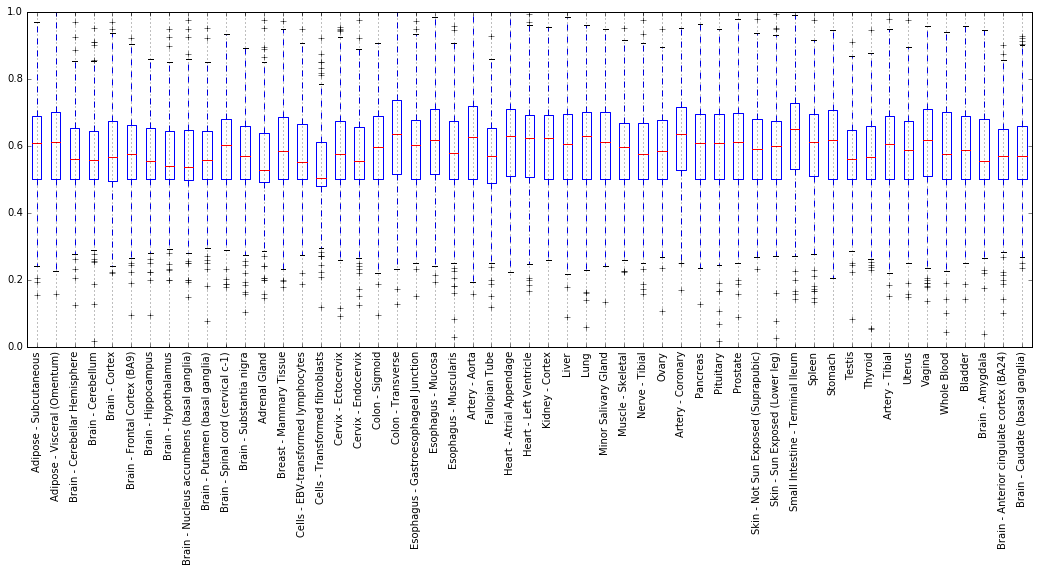

In [64]:
make_boxplot(aucs, all_tissues)

In [ ]:
## For fixing folders with _server postfix.

In [51]:
results_path = 'pca_results_1_tissue/'
results_dir = [f for f in listdir(results_path) if join(results_path, f)]

In [52]:
for d in results_dir:
    if 'server' in d:
        server_index = d.index('server')
        new_d = d[:server_index-1]
        if not exists(new_d):
            makedirs(results_path + new_d)
        
        rename(results_path + d, results_path + new_d)

t_
